In [ ]:
# !pip install findspark
import findspark
findspark.init()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [ ]:
spark = SparkSession.builder.getOrCreate() # Creating Spark Session

In [2]:
spark

# Plays Data

In [3]:
# dataframe Schema creation.
play_data_schema = StructType(
  [StructField('User_ID', StringType()),
   StructField('Song_ID', StringType()),
   StructField('Play_Count', IntegerType())]
)

In [4]:
#reading data into a Spark dataframe.
play_data = spark.read.options(delimiter = ',', header=False,inferSchema=False) \
                         .schema(play_data_schema) \
                         .csv("triplets_sample.csv")


# Our S3 datafiles folder in AWS
#s3://603project//filename

# Our Hadoop datafiles folder
# hdfs://localhost:9000/603project/filename

In [5]:
play_data.show(5)

+--------------------+------------------+----------+
|             User_ID|           Song_ID|Play_Count|
+--------------------+------------------+----------+
|b80344d063b5ccb32...|SOWEZSI12A81C21CE6|         1|
|4bd88bfb25263a75b...|SODCXXY12AB0187452|         2|
|4bd88bfb25263a75b...|SOWPAXV12A67ADA046|        18|
|b64cdd1a0bd907e5e...|SOLXDDC12A6701FBFD|         1|
|b64cdd1a0bd907e5e...|SONJBQX12A6D4F8382|         4|
+--------------------+------------------+----------+
only showing top 5 rows



In [6]:
play_data.count()

700

# Tracks to Song Data

In [7]:
#creating Schema.
tracks_schema = StructType(
                           [StructField("Track_ID", StringType()),
                            StructField("Song_ID", StringType()),
                            StructField("Artist", StringType()),
                            StructField("Title", StringType())    
                           ])

In [8]:
#reading data into dataframe.
tracks_data = spark.read.options(delimiter = ',', header=False,inferSchema=False) \
                         .schema(tracks_schema) \
                         .csv('unquie_tracks_sample.csv')


# Our S3 datafiles folder in AWS
#s3://603project//filename

# Our Hadoop datafiles folder
# hdfs://localhost:9000/603project/filename

In [9]:
tracks_data.show(5)

+------------------+------------------+-----------+-----------------+
|          Track_ID|           Song_ID|     Artist|            Title|
+------------------+------------------+-----------+-----------------+
|TRAUCNU128F42671EB|SOWEZSI12A81C21CE6|Gipsy Kings|Tu Quieres Volver|
|TRBFXMJ12903CB50F6|SODCXXY12AB0187452| brokeNCYDE|          Freaxxx|
|TRBBMHE128EF341D09|SOWPAXV12A67ADA046|Salt-N-Pepa|          Push It|
|TRAUURC128E078EC6E|SOLXDDC12A6701FBFD|     Eminem|         I'm Back|
|TRAQVTO128F14696A6|SONJBQX12A6D4F8382|  Daft Punk|          Da Funk|
+------------------+------------------+-----------+-----------------+
only showing top 5 rows



In [10]:
tracks_data.count()

700

# Checking NULL values

In [11]:
play_data.select([count(when(isnan(c), c)).alias(c) for c in play_data.columns]).show()
# play_data.where(col("User_ID").isNull()).show()

+-------+-------+----------+
|User_ID|Song_ID|Play_Count|
+-------+-------+----------+
|      0|      0|         0|
+-------+-------+----------+



In [12]:
tracks_data.select([count(when(isnan(c), c)).alias(c) for c in tracks_data.columns]).show()

+--------+-------+------+-----+
|Track_ID|Song_ID|Artist|Title|
+--------+-------+------+-----+
|       0|      0|     0|    0|
+--------+-------+------+-----+



# Subsetting the Play_Data

In [13]:
df = play_data.join(tracks_data, on = ["Song_ID"], how = "inner")

In [14]:
df.printSchema()

root
 |-- Song_ID: string (nullable = true)
 |-- User_ID: string (nullable = true)
 |-- Play_Count: integer (nullable = true)
 |-- Track_ID: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Title: string (nullable = true)



In [15]:
df.show(5)

+------------------+--------------------+----------+------------------+-----------+-----------------+
|           Song_ID|             User_ID|Play_Count|          Track_ID|     Artist|            Title|
+------------------+--------------------+----------+------------------+-----------+-----------------+
|SOWEZSI12A81C21CE6|b80344d063b5ccb32...|         1|TRAUCNU128F42671EB|Gipsy Kings|Tu Quieres Volver|
|SODCXXY12AB0187452|4bd88bfb25263a75b...|         2|TRBFXMJ12903CB50F6| brokeNCYDE|          Freaxxx|
|SOWPAXV12A67ADA046|2a294bd589db99006...|         1|TRBBMHE128EF341D09|Salt-N-Pepa|          Push It|
|SOWPAXV12A67ADA046|529b42cdbc379ad2e...|         4|TRBBMHE128EF341D09|Salt-N-Pepa|          Push It|
|SOWPAXV12A67ADA046|0a00498b9d607844a...|         2|TRBBMHE128EF341D09|Salt-N-Pepa|          Push It|
+------------------+--------------------+----------+------------------+-----------+-----------------+
only showing top 5 rows



In [16]:
# df.select("Song_ID").distinct().count()

In [17]:
df.count()

3962

# Descriptive Statistics

In [18]:
# Unique Users

users = df.select('User_ID').distinct().count()
users

386

In [19]:
# Unique Songs
songs = df.select('Song_ID').distinct().count()
songs

335

In [20]:
# play count statistics
df.select("Play_Count").describe().show()

+-------+------------------+
|summary|        Play_Count|
+-------+------------------+
|  count|              3962|
|   mean|2.4126703685007573|
| stddev|2.8728980196713856|
|    min|                 1|
|    max|                24|
+-------+------------------+



In [21]:
# User activity
user_activity = df.groupBy('User_ID').sum('Play_Count').toPandas()
user_activity.describe(percentiles=[.25, .50, .75, .90, .99, .999])

,sum(Play_Count)
count,386.000000
mean,24.764249
std,44.303134
min,1.000000
25%,3.000000
50%,9.000000
75%,24.750000
90%,64.500000
99%,226.350000
99.9%,360.705000


# Exploratory Data Analysis

In [22]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Top 10 Popular Songs based on their play count

In [23]:
pd_df1 = df.groupBy('Title').sum('Play_Count').sort(desc('sum(Play_Count)'))

In [24]:
# pd_df1.cache()

In [25]:
pd_df1 = pd_df1.limit(10).toPandas() # Spark dataframe into pandas dataframe.

In [26]:
pd_df1.shape

(10, 2)

In [27]:
pd_df1.head()

,Title,sum(Play_Count)
0,Supermassive Black Hole (Album Version),1875
1,Nothin' On You [feat. Bruno Mars] (Album Version),1128
2,Angie (1993 Digital Remaster),912
3,Hips Don't Lie (featuring Wyclef Jean),595
4,Check On It,528


In [28]:
#pd_df1.info()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


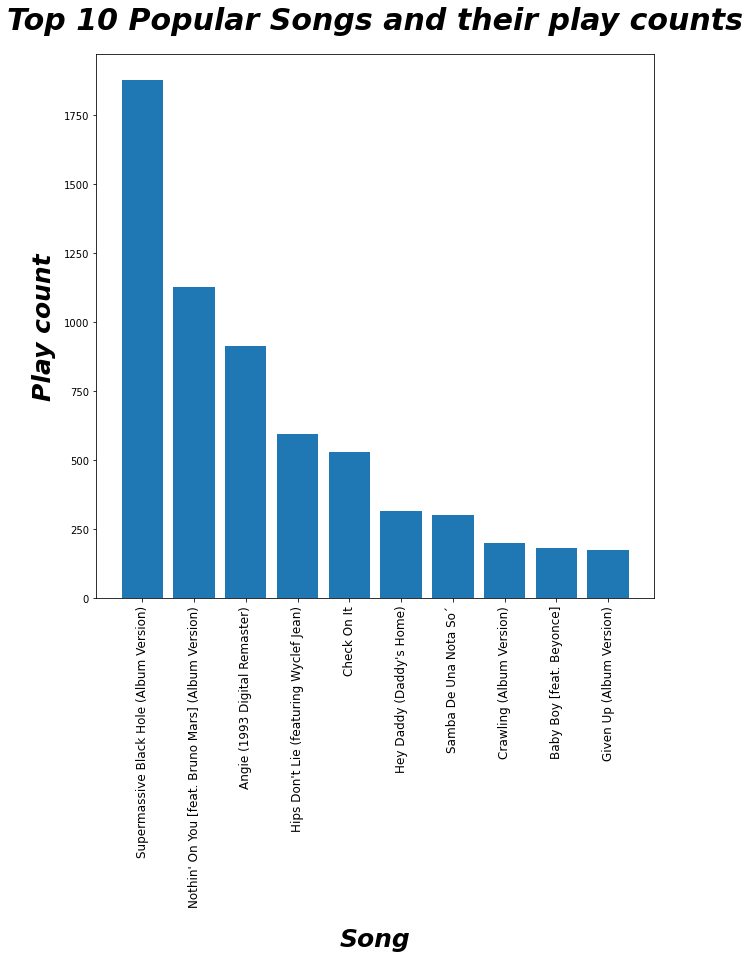

In [29]:
# plotting the  Bar plot
plt.rcParams['figure.figsize']=(10,10)
plt.bar(x=pd_df1['Title'], height = pd_df1['sum(Play_Count)'])
plt.title("Top 10 Popular Songs and their play counts", pad =25, fontsize='30',fontweight='bold', fontname="Times New Roman", style='italic')
plt.ylabel('Play count', fontweight='bold', color = 'Black', fontsize='25', 
           verticalalignment='center', labelpad=20, fontname="Times New Roman", style='italic')# ylabel function is used for labelling the Y-axis.

plt.xlabel('Song',fontweight='bold', color = 'Black', fontsize='25',
           horizontalalignment='center', labelpad=20, fontname="Times New Roman", style='italic') # xlabel function is used for labelling the X-axis.
plt.xticks(fontname="Times New Roman", rotation='vertical', fontsize='12')
plt.show()

# 
# Top 10 Popular Artistist according to their songs play Count

In [30]:
pd_df2 = df.groupBy('Artist').sum('Play_Count').sort(desc('sum(Play_Count)'))

In [31]:
# pd_df2.cache()

In [32]:
pd_df2 = pd_df2.limit(10).toPandas()

In [33]:
pd_df2.shape

(10, 2)

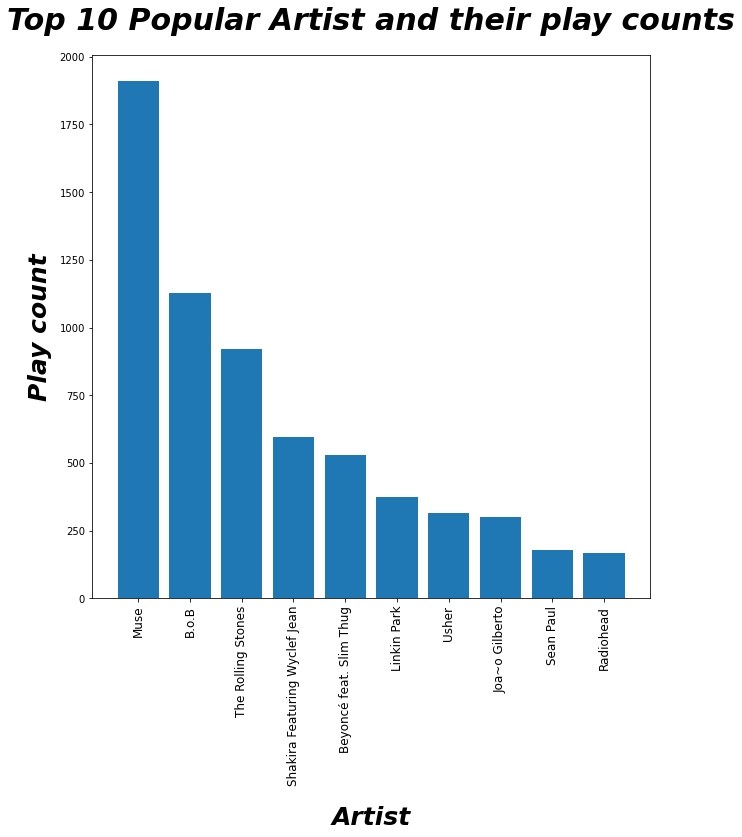

In [34]:
plt.rcParams['figure.figsize']=(10,10)
plt.bar(x=pd_df2['Artist'], height = pd_df2['sum(Play_Count)'])
plt.title("Top 10 Popular Artist and their play counts", pad =25, fontsize='30',fontweight='bold', fontname="Times New Roman", style='italic')
plt.ylabel('Play count', fontweight='bold', color = 'Black', fontsize='25', 
           verticalalignment='center', labelpad=20, fontname="Times New Roman", style='italic')# ylabel function is used for labelling the Y-axis.

plt.xlabel('Artist',fontweight='bold', color = 'Black', fontsize='25',
           horizontalalignment='center', labelpad=20, fontname="Times New Roman", style='italic') # xlabel function is used for labelling the X-axis.
plt.xticks(fontname="Times New Roman", rotation='vertical', fontsize='12')
plt.show()

# 
# Top 10 Popular Artist based on the Audience

In [35]:
pd_df3 = df.groupBy('Artist').agg(countDistinct("User_ID")).orderBy('count(User_ID)', ascending=False)

In [36]:
# pd_df3.cache()

In [37]:
pd_df3 = pd_df3.limit(10).toPandas()

In [38]:
pd_df3.shape

(10, 2)

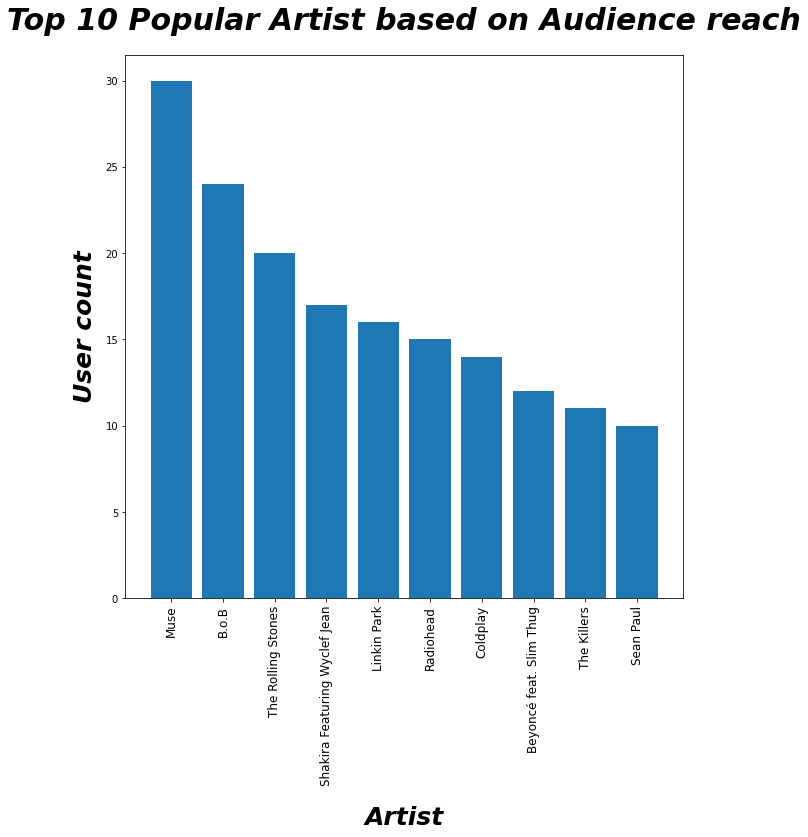

In [39]:
# plt.rcParams['figure.figsize']=(10,10)
plt.bar(x=pd_df3['Artist'], height = pd_df3['count(User_ID)'])
plt.title("Top 10 Popular Artist based on Audience reach", pad =25, fontsize='30',fontweight='bold', fontname="Times New Roman", style='italic')
plt.ylabel('User count', fontweight='bold', color = 'Black', fontsize='25', 
           verticalalignment='center', labelpad=20, fontname="Times New Roman", style='italic')# ylabel function is used for labelling the Y-axis.

plt.xlabel('Artist',fontweight='bold', color = 'Black', fontsize='25',
           horizontalalignment='center', labelpad=20, fontname="Times New Roman", style='italic') # xlabel function is used for labelling the X-axis.
plt.xticks(fontname="Times New Roman", rotation='vertical', fontsize='12')
plt.show()

# Recommendation System

### Preparing data for applying Machine learning algorithms

In [40]:
# Creating Integer ID's
#Pyspark's ALS machine learning model can only consume user ID's and Song ID's as Integers. 
# So We have converting the Id's to integer type.

In [41]:
from pyspark.ml.feature import StringIndexer

In [42]:
user_int = StringIndexer(inputCol = 'User_ID',
                        outputCol = 'User_IntID')

In [43]:
user_int_model = user_int.fit(df)

In [44]:
df = user_int_model.transform(df)

In [45]:
df.show(n = 5, vertical=True)

-RECORD 0--------------------------
 Song_ID    | SOWEZSI12A81C21CE6   
 User_ID    | b80344d063b5ccb32... 
 Play_Count | 1                    
 Track_ID   | TRAUCNU128F42671EB   
 Artist     | Gipsy Kings          
 Title      | Tu Quieres Volver    
 User_IntID | 366.0                
-RECORD 1--------------------------
 Song_ID    | SODCXXY12AB0187452   
 User_ID    | 4bd88bfb25263a75b... 
 Play_Count | 2                    
 Track_ID   | TRBFXMJ12903CB50F6   
 Artist     | brokeNCYDE           
 Title      | Freaxxx              
 User_IntID | 190.0                
-RECORD 2--------------------------
 Song_ID    | SOWPAXV12A67ADA046   
 User_ID    | 2a294bd589db99006... 
 Play_Count | 1                    
 Track_ID   | TRBBMHE128EF341D09   
 Artist     | Salt-N-Pepa          
 Title      | Push It              
 User_IntID | 155.0                
-RECORD 3--------------------------
 Song_ID    | SOWPAXV12A67ADA046   
 User_ID    | 529b42cdbc379ad2e... 
 Play_Count | 4             

In [46]:
#validating
# df.select('User_ID').distinct().count() == df.select('User_IntID').distinct().count()

In [47]:
song_int = StringIndexer(inputCol = 'Song_ID',
                        outputCol = 'Song_IntID')

In [48]:
song_int_model = song_int.fit(df)

In [49]:
df = song_int_model.transform(df)

In [50]:
# df.show(n = 5, vertical=True)

In [51]:
# df.cache()

In [52]:
#validating
# df.select('Song_ID').distinct().count() == df.select('Song_IntID').distinct().count()

# Collaborative Filtering
> Basic Idealogy behind Collaborative filtering is to find a users with similar interest and recommend products to a user who has the same taste as that of the users in that cluster. For example if a user say "A" listens to a song 1, 3 and 5 and if a user "B" listens to songs 1 and 5 then the collaborative filtering algorithm recommends song 3 to the User B .


> Collaborative filtering works by converting the users and the products in to matrix and later factorizes it to find the latent or hidden features to see what binds the users and the products and based on those features it recommends the products to the users.

> Lets say if X is a user-song matrix of size i*j, then the factored matrices will be users of size i*k and songs of size K*j


Reference:
https://towardsdatascience.com/intro-to-recommender-system-collaborative-filtering-64a238194a26

# Alternating Least Squares

> ALS is a collaborative filtering algorithm, which helps find latent features by factorizing in a unique way. As the name indicates it factorizes the matrix first by keeping user matrix's latent features constant to find the songs latent features and later keeps the songs latent features fixed to find the user's latent features. It repeats this process of switching back and forth untils it finds and optimal solution.

> The optimal solution here is A matrix close to the user song matrix (when both the factored matrices are multiplied).

Reference:
https://www.youtube.com/watch?v=K7TG_EX39OA

In [53]:
# train test split
(train, test) = df.randomSplit([0.8, 0.2])

In [54]:
from pyspark.ml.recommendation import ALS
# from pyspark.mllib.evaluation import RankingMetrics

In [55]:
als = ALS(implicitPrefs = True, userCol = 'User_IntID', itemCol = 'Song_IntID', ratingCol = 'Play_Count')

In [56]:
als_model = als.fit(train)

In [57]:
als_predict = als_model.transform(test)

In [58]:
# Reference: https://datascience.stackexchange.com/questions/64707/calculating-rank-ordering-error-metric-for-implicit-recommendation
# Ranking Metric to check if the songs with higher play count have higher prediction rate.
def Rank_Eval(predictions, userCol = 'User_IntID', itemCol = 'Song_IntID', ratingCol = 'Play_Count'):
    predictions.createOrReplaceTempView("predictions")
    
    denom = predictions.groupBy().sum(ratingCol).collect()[0][0]
    spark.sql("SELECT " + userCol + "," + ratingCol + ", PERCENT_RANK() OVER (PARTITION BY " + userCol + " ORDER BY prediction DESC) AS rank FROM predictions").createOrReplaceTempView("rankings")
    
    numer = spark.sql("SELECT SUM (" + ratingCol + " * rank) FROM rankings").collect()[0][0]
    
    Eval = numer/denom
    
    return Eval

In [59]:
evaluate = Rank_Eval(als_predict)
print(evaluate)

0.15602685060846827


In [60]:
als_predict.show()

+------------------+--------------------+----------+------------------+--------------------+--------------------+----------+----------+------------+
|           Song_ID|             User_ID|Play_Count|          Track_ID|              Artist|               Title|User_IntID|Song_IntID|  prediction|
+------------------+--------------------+----------+------------------+--------------------+--------------------+----------+----------+------------+
|SOCWAFA12A8AE48A78|1b704d4cddabea825...|         1|TRBFVAA128F423C356|         The Prodigy|Wake Up Call (Alb...|       8.0|     148.0|         NaN|
|SOLXDDC12A6701FBFD|bd64f193f0f53f09d...|         1|TRAUURC128E078EC6E|              Eminem|            I'm Back|     160.0|      31.0|  0.70801216|
|SOADCFY12A6310E353|8207221df7894bb77...|         1|TRBCVBK128E07813EC|            Gorillaz|Rock The House (R...|     217.0|      65.0|1.6282906E-8|
|SOPOJVI12A58A7E706|fb2f2c0e39e233622...|         1|TRALMTD128E07862AC|              Redman|             J

# Few recommended songs to each user

In [61]:
# we have used this fuction only cause we sampled the data. 
# sampling data caused to recommend same song multiple times
def unique_recom(a):
    l1=a.split(",")
    s1=set(l1)
    str1=", ".join(s1)
    return str1

In [62]:
spark.udf.register("song_dis",unique_recom)

<function __main__.unique_recom(a)>

In [63]:
# Temp view
spark.sql("select t1.User_IntID,song_dis(concat_ws(',', collect_list(t1.Title)))`recommended songs` \
          from (select * from (select *,avg(prediction) over(partition by User_IntID)`av` \
          from predictions order by User_IntID)t where t.prediction>t.av)t1 group by  \
          t1.User_IntID order by t1.User_IntID").show(vertical=True,truncate=100)

-RECORD 0-----------------------------------------------------------------------------------------------------------------
 User_IntID        | 1.0                                                                                                  
 recommended songs | Crawling (Album Version), Supermassive Black Hole (Album Version), Hips Don't Lie (featuring Wycl... 
-RECORD 1-----------------------------------------------------------------------------------------------------------------
 User_IntID        | 2.0                                                                                                  
 recommended songs | Supermassive Black Hole (Album Version), Nothin' On You [feat. Bruno Mars] (Album Version)           
-RECORD 2-----------------------------------------------------------------------------------------------------------------
 User_IntID        | 3.0                                                                                                  
 recommended son

# Content Based Filtering

In [64]:
# dataframe Schema creation. 
lyrics_schema = StructType(
  [StructField('Tracks_ID', StringType()),
   StructField('MXM_ID', IntegerType()),
   StructField('Word', StringType()),
  StructField('Count', IntegerType()),
  StructField('Is_true', IntegerType())]
)

In [65]:
#reading data into a Spark dataframe. Lyrics Bag of words Data
lyrics_data = spark.read.options(delimiter = ',', header=False,inferSchema=False)\
                         .csv("lyrics_smaple.csv", schema = lyrics_schema)


# Our S3 datafiles folder in AWS
#s3://603project//filename

# Our Hadoop datafiles folder
# hdfs://localhost:9000/603project/filename

In [66]:
lyrics_data.show() # Lyrics Data

+------------------+-------+----+-----+-------+
|         Tracks_ID| MXM_ID|Word|Count|Is_true|
+------------------+-------+----+-----+-------+
|TRAAAAV128F421A322|4623710|   i|    6|      0|
|TRAAAAV128F421A322|4623710| the|    4|      0|
|TRAAAAV128F421A322|4623710| you|    2|      0|
|TRAAAAV128F421A322|4623710|  to|    2|      0|
|TRAAAAV128F421A322|4623710| and|    5|      0|
|TRAAAAV128F421A322|4623710|   a|    3|      0|
|TRAAAAV128F421A322|4623710|  me|    1|      0|
|TRAAAAV128F421A322|4623710|  it|    1|      0|
|TRAAAAV128F421A322|4623710|  my|    1|      0|
|TRAAAAV128F421A322|4623710|  is|    2|      0|
|TRAAAAV128F421A322|4623710|  of|    3|      0|
|TRAAAAV128F421A322|4623710|your|    1|      0|
|TRAAAAV128F421A322|4623710|that|    1|      0|
|TRAAAAV128F421A322|4623710| are|    2|      0|
|TRAAAAV128F421A322|4623710|  we|    2|      0|
|TRAAAAV128F421A322|4623710|  am|    2|      0|
|TRAAAAV128F421A322|4623710|will|    2|      0|
|TRAAAAV128F421A322|4623710| for|    4| 

# Checking NULL values

In [67]:
lyrics_data.select([count(when(isnan(c), c)).alias(c) for c in lyrics_data.columns]).show()

+---------+------+----+-----+-------+
|Tracks_ID|MXM_ID|Word|Count|Is_true|
+---------+------+----+-----+-------+
|        0|     0|   0|    0|      0|
+---------+------+----+-----+-------+



# Preprocessing the Data

In [68]:
# !pip install nltk #installing NLTK module
# nltk.download() # downloading all the NLTK packages

In [69]:
from nltk.corpus import stopwords

In [70]:
# print(stopwords.words('english'))
stop_words = stopwords.words('english') #getting all the english stopwords into a list

In [71]:
# removing stop words
lyrics_noStopwords = lyrics_data.filter(~lyrics_data.Word.isin(stop_words))

In [72]:
# lyrics_noStopwords.show(5)

In [73]:
# lyrics_noStopwords.count()

In [74]:
# Schema of lyrics stopwords
lyrics_noStopwords.printSchema()

root
 |-- Tracks_ID: string (nullable = true)
 |-- MXM_ID: integer (nullable = true)
 |-- Word: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Is_true: integer (nullable = true)



In [75]:
# creating a new column lyrics = word * count i.e repeating the word based on its count.
lyrics_noStopwords=lyrics_noStopwords.withColumn("lyrics", \
                                                 array_repeat(lyrics_noStopwords.Word, lyrics_noStopwords.Count))

# lyrics_noStopwords.show()

In [76]:
# Schema
lyrics_noStopwords.printSchema()

root
 |-- Tracks_ID: string (nullable = true)
 |-- MXM_ID: integer (nullable = true)
 |-- Word: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- Is_true: integer (nullable = true)
 |-- lyrics: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [77]:
# Function to concat the words to make it as a string
def join(xyz):
    
    eq=" ".join(xyz)
    return eq

In [78]:
# udf is like apply function in pandas which apply function to each and every row. 
# It makes ordinary python code into something scalable.

join_udf=udf(join)

In [79]:
# Joining the words
lyrics_noStopwords=lyrics_noStopwords.withColumn("str",join_udf("lyrics"))

In [80]:
# lyrics_noStopwords.show(5)

In [81]:
# Creating a Hive Temp View
lyrics_noStopwords.createOrReplaceTempView("df")

In [82]:
# spark.sql("select * from df")

In [83]:
# SQL code to concat all the words that belong to same Track_ID
lyrics_noStopwords = spark.sql("select Tracks_ID, concat_ws(' ',collect_list(str))`lyrics` \
                               from df group by Tracks_ID,MXM_ID")

In [84]:
# lyrics_noStopwords.show()

In [85]:
# Sampling the data to make it more managable.
newdf=lyrics_noStopwords.limit(100)

In [86]:
# Dispalying the dataframe
newdf.show()

+------------------+--------------------+
|         Tracks_ID|              lyrics|
+------------------+--------------------+
|TRAAABD128F429CF47|know know know kn...|
|TRAAAFD128F92F423A|one got never fee...|
|TRAAAEW128F42930C0|like take would w...|
|TRAAAHJ128F931194C|love time never n...|
|TRAAAED128E0783FAB|love love love lo...|
|TRAAAOF128F429C156|know know know li...|
|TRAAAHZ128E0799171|love love know li...|
|TRAAAJG128F9308A25|like one get ca c...|
|TRAAAEF128F4273421|know got got got ...|
|TRAAAAV128F421A322|like like de got ...|
|TRAAAGF12903CEC202|en e end du du et...|
+------------------+--------------------+



In [87]:
# cross joining the data so that we can find consine similarity between each and every lyrics
dfnew = newdf.crossJoin(newdf.selectExpr("Tracks_ID as Id","lyrics as ly"))

In [88]:
# columns in our new dataframe
dfnew.columns

['Tracks_ID', 'lyrics', 'Id', 'ly']

In [89]:
# dfnew.show()

In [90]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF

In [91]:
# tokenizing the lyrics
tokenizer = Tokenizer(inputCol='lyrics', outputCol='words')
df2 = tokenizer.transform(dfnew)

In [92]:
# df2.show()

In [93]:
# tokeninzing the lyrics
tokenizer = Tokenizer(inputCol='ly', outputCol='words2')
df2 = tokenizer.transform(df2)

In [94]:
# df2.show()

In [95]:
# Term freaquency vectors of the tokenized lyrics
tf_hasher = HashingTF(numFeatures=15, binary=True, inputCol='words', outputCol='tf_vector')
tf_hasher1 = HashingTF(numFeatures=15, binary=True, inputCol='words2', outputCol='tf_vector2')

In [96]:
# Trasforming the tokens into term frequency vectors
df2 = tf_hasher.transform(df2)
df2 = tf_hasher1.transform(df2)

In [97]:
df2.show(5, vertical=True)

-RECORD 0--------------------------
 Tracks_ID  | TRAAABD128F429CF47   
 lyrics     | know know know kn... 
 Id         | TRAAABD128F429CF47   
 ly         | know know know kn... 
 words      | [know, know, know... 
 words2     | [know, know, know... 
 tf_vector  | (15,[0,1,2,3,4,5,... 
 tf_vector2 | (15,[0,1,2,3,4,5,... 
-RECORD 1--------------------------
 Tracks_ID  | TRAAABD128F429CF47   
 lyrics     | know know know kn... 
 Id         | TRAAAFD128F92F423A   
 ly         | one got never fee... 
 words      | [know, know, know... 
 words2     | [one, got, never,... 
 tf_vector  | (15,[0,1,2,3,4,5,... 
 tf_vector2 | (15,[0,1,2,3,4,5,... 
-RECORD 2--------------------------
 Tracks_ID  | TRAAABD128F429CF47   
 lyrics     | know know know kn... 
 Id         | TRAAAEW128F42930C0   
 ly         | like take would w... 
 words      | [know, know, know... 
 words2     | [like, take, woul... 
 tf_vector  | (15,[0,1,2,3,4,5,... 
 tf_vector2 | (15,[0,1,2,3,4,5,... 
-RECORD 3-------------------

In [98]:
# converting Term frequencies into TF-IDF vectors

idf = IDF(inputCol="tf_vector", outputCol='tf_idf_vector')
idf1 = IDF(inputCol="tf_vector2", outputCol='tf_idf_vector2')
idf_model = idf.fit(df2)
idf_model1 = idf1.fit(df2)
df2 = idf_model.transform(df2)
df2 = idf_model1.transform(df2)

In [99]:
df2.show(100,vertical=True)

-RECORD 0------------------------------
 Tracks_ID      | TRAAABD128F429CF47   
 lyrics         | know know know kn... 
 Id             | TRAAABD128F429CF47   
 ly             | know know know kn... 
 words          | [know, know, know... 
 words2         | [know, know, know... 
 tf_vector      | (15,[0,1,2,3,4,5,... 
 tf_vector2     | (15,[0,1,2,3,4,5,... 
 tf_idf_vector  | (15,[0,1,2,3,4,5,... 
 tf_idf_vector2 | (15,[0,1,2,3,4,5,... 
-RECORD 1------------------------------
 Tracks_ID      | TRAAABD128F429CF47   
 lyrics         | know know know kn... 
 Id             | TRAAAFD128F92F423A   
 ly             | one got never fee... 
 words          | [know, know, know... 
 words2         | [one, got, never,... 
 tf_vector      | (15,[0,1,2,3,4,5,... 
 tf_vector2     | (15,[0,1,2,3,4,5,... 
 tf_idf_vector  | (15,[0,1,2,3,4,5,... 
 tf_idf_vector2 | (15,[0,1,2,3,4,5,... 
-RECORD 2------------------------------
 Tracks_ID      | TRAAABD128F429CF47   
 lyrics         | know know know kn... 


In [100]:
from pyspark.ml.linalg import *

In [101]:
def cosine_similarity(u, v):
    numer = v.dot(u)
    denom = (v.norm(2) * u.norm(2))
    l1=[]
    if denom == 0:
        return 0
    else:
        #l1.append(numer/denom)
        return (float(numer/denom))

In [102]:
cosine_similarity_udf = udf(cosine_similarity)

In [103]:
df_cos = df2.withColumn('cosine_similarity', cosine_similarity_udf(df2.tf_idf_vector, df2.tf_idf_vector2))
df_cos.show(5, vertical = True)

-RECORD 0---------------------------------
 Tracks_ID         | TRAAABD128F429CF47   
 lyrics            | know know know kn... 
 Id                | TRAAABD128F429CF47   
 ly                | know know know kn... 
 words             | [know, know, know... 
 words2            | [know, know, know... 
 tf_vector         | (15,[0,1,2,3,4,5,... 
 tf_vector2        | (15,[0,1,2,3,4,5,... 
 tf_idf_vector     | (15,[0,1,2,3,4,5,... 
 tf_idf_vector2    | (15,[0,1,2,3,4,5,... 
 cosine_similarity | 1.0000000000000002   
-RECORD 1---------------------------------
 Tracks_ID         | TRAAABD128F429CF47   
 lyrics            | know know know kn... 
 Id                | TRAAAFD128F92F423A   
 ly                | one got never fee... 
 words             | [know, know, know... 
 words2            | [one, got, never,... 
 tf_vector         | (15,[0,1,2,3,4,5,... 
 tf_vector2        | (15,[0,1,2,3,4,5,... 
 tf_idf_vector     | (15,[0,1,2,3,4,5,... 
 tf_idf_vector2    | (15,[0,1,2,3,4,5,... 
 cosine_sim

In [104]:
df_cos.createOrReplaceTempView("recom")

In [105]:
x = input() # provide any track Id from the lyrics.csv file

TRAAAFD128F92F423A


In [106]:
# Few recommendations based on the Track ID provided.
spark.sql("select Id`Recommended songs` from recom where Tracks_ID='"+ x +"' \
          and (cosine_similarity >0.9 and cosine_similarity<1) limit 5").show()

+------------------+
| Recommended songs|
+------------------+
|TRAAAEW128F42930C0|
|TRAAAJG128F9308A25|
+------------------+

